In [1]:
import pandas_datareader.data as web 
import pandas as pd 
import numpy as np 
import yfinance as yf 
from datetime import datetime, date, time 
import matplotlib.pyplot as plt 
%matplotlib inline 

from hmmlearn import hmm

import warnings 
warnings.filterwarnings('ignore')

In [9]:
macro_symbols = {'sp500': {'cpi': 'CPIAUCSL', 'index': '^GSPC', 'vix': '^VIX'}, 
                 'nifty': {'cpi': 'INDCPALTT01IXNBM', 'index': '^NSEI', 'vix': '^INDIAVIX'}} 

### Data Formatting 

In [2]:
def clean_format_data(index_type):
    if index_type == 'sp500':
        cpi = macro_symbols['sp500']['cpi']
        index = macro_symbols['sp500']['index'] 
        vix = macro_symbols['sp500']['vix']

        econ_data = web.DataReader([cpi], 'fred', start=datetime(2000, 1, 1), end=datetime(2024, 12, 31))
        econ_data['inflation'] = econ_data[cpi]/econ_data[cpi].shift(12) - 1
        econ_data = econ_data.dropna(axis=0)

        index_data = yf.download([index, vix], start=datetime(2000, 12, 1), end=datetime(2024, 12, 31), auto_adjust=False)
        idx_adj_close = index_data['Adj Close']
        idx_adj_close_monthly = idx_adj_close.resample('BMS').first()
        idx_monthly_returns = idx_adj_close_monthly.pct_change()

        econ_data = econ_data.reset_index()
        idx_monthly_returns = idx_monthly_returns.reset_index()
        econ_data['yyyy-mm'] = econ_data['DATE'].dt.strftime('%Y-%m')
        idx_monthly_returns['yyyy-mm'] = idx_monthly_returns['Date'].dt.strftime('%Y-%m')
        final = pd.merge(econ_data, idx_monthly_returns, on='yyyy-mm')

        final = final.drop(['yyyy-mm', 'Date', cpi], axis=1)
        final.columns = ['date', 'inflation', 'index', 'vix']
        final = final[['date', 'inflation', 'index', 'vix']] 
        final = final.set_index('date')
        
        return final 
    elif index_type == 'nifty':
        cpi = macro_symbols['nifty']['cpi']
        index = macro_symbols['nifty']['index'] 
        vix = macro_symbols['nifty']['vix']
        
        econ_data = web.DataReader([cpi], 'fred', start=datetime(2000, 1, 1), end=datetime(2024, 12, 31))
        econ_data['inflation'] = econ_data[cpi]/econ_data[cpi].shift(12) - 1
        econ_data = econ_data.dropna(axis=0)
        
        index_data = yf.download([index], start=datetime(2000, 12, 1), end=datetime(2024, 12, 31), auto_adjust=False)
        idx_adj_close = index_data['Adj Close']
        idx_adj_close_monthly = idx_adj_close.resample('BMS').first()
        idx_monthly_returns = idx_adj_close_monthly.pct_change()
        
        vix_data = pd.read_csv('indiavix.csv')
        vix_data['date'] = pd.to_datetime(vix_data['date'])
        vix_data = vix_data.set_index('date')
        vix_close = vix_data['close']
        vix_close_monthly = vix_close.resample('BMS').first()
        vix_monthly_returns = vix_close_monthly.pct_change()
        
        econ_data = econ_data.reset_index()
        idx_monthly_returns = idx_monthly_returns.reset_index()
        vix_monthly_returns = vix_monthly_returns.reset_index()
        econ_data['yyyy-mm'] = econ_data['DATE'].dt.strftime('%Y-%m')
        idx_monthly_returns['yyyy-mm'] = idx_monthly_returns['Date'].dt.strftime('%Y-%m')
        vix_monthly_returns['yyyy-mm'] = vix_monthly_returns['date'].dt.strftime('%Y-%m')
        final = pd.merge(econ_data, idx_monthly_returns, on='yyyy-mm').merge(vix_monthly_returns, on='yyyy-mm')
        
        final = final.drop(['yyyy-mm', 'Date', 'date', cpi], axis=1)
        final.columns = ['date', 'inflation', 'index', 'vix']
        final = final[['date', 'inflation', 'index', 'vix']] 
        final = final.set_index('date').dropna(axis=0)     

        return final
    else: 
        print(f'''Index not specified''')
        return pd.DataFrame()

### Plot Regimes of Macroeconomic indicators 

In [53]:
def plot_regimes(final):
    fig = plt.figure(figsize=(5, 8), layout="constrained")
    gs = fig.add_gridspec(3, 1)
    
    def plot_func(group):
        nonlocal ax
        if (group['regimes'] == 0).all():
            color = 'g'
        else:
            color = 'r'     
        
        lw = 2.0 
        ax.plot(group.index, group.cum, c=color, linewidth=lw, linestyle='solid')
        ax.set_xlabel('Date')
        ax.set_ylabel('Indicator Value')
        ax.set_title(f'''Economic Indicator: {c_name}''')
    
    row = 0
    regimes = pd.DataFrame(columns=final.columns)
    for c_name in final.columns:
        ax = fig.add_subplot(gs[row, 0])
        df = final[[c_name]].replace([-np.inf, np.inf], np.nan).ffill().bfill()
        df['cum'] = df[c_name].cumsum()
        model = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
        model.fit(df[c_name].to_numpy().reshape(-1, 1))
        df['regimes'] = model.predict(df[c_name].to_numpy().reshape(-1, 1))
        regimes[c_name] = df[['regimes']].copy()
        df['diff'] = (df['regimes'].shift() != df['regimes']).cumsum()
        df.groupby(['diff']).apply(plot_func)
        row += 1    
    plt.show()
    regimes = regimes.add_prefix('ind_')
    return regimes

[*********************100%***********************]  2 of 2 completed


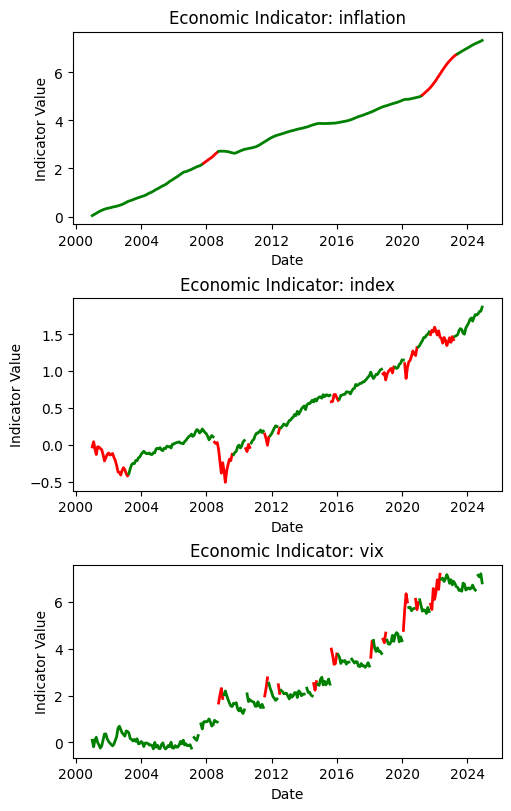

               mean_inflation  std_inflation
ind_inflation                               
0                    0.020358       0.011253
1                    0.060090       0.016317
           mean_index  std_index
ind_index                       
0            0.013905   0.025936
1           -0.008812   0.073594
         mean_vix   std_vix
ind_vix                    
0       -0.025476  0.146828
1        0.303780  0.445473


In [60]:
ticker_data = clean_format_data('sp500')
regimes = plot_regimes(ticker_data)
ticker_data = pd.concat([ticker_data, regimes], axis=1)
print(ticker_data.groupby(['ind_inflation']).agg(mean_inflation=('inflation', 'mean'),
                                           std_inflation=('inflation', 'std')))
print(ticker_data.groupby(['ind_index']).agg(mean_index=('index', 'mean'),
                                       std_index=('index', 'std')))        
print(ticker_data.groupby(['ind_vix']).agg(mean_vix=('vix', 'mean'),
                                     std_vix=('vix', 'std')))

[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 287.5136290153923 is not greater than 287.51415586423036. Delta is -0.000526848838035221


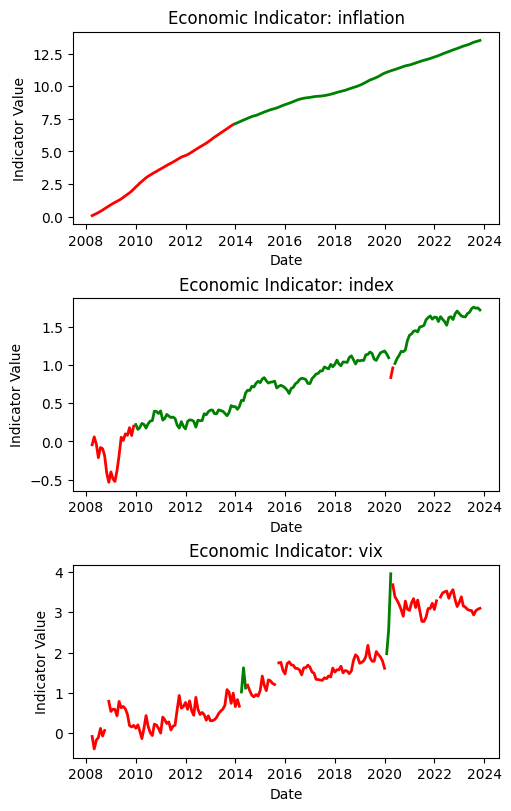

               mean_inflation  std_inflation
ind_inflation                               
0                    0.054198       0.015697
1                    0.102217       0.020157
           mean_index  std_index
ind_index                       
0            0.010000   0.043310
1            0.002921   0.137631
         mean_vix   std_vix
ind_vix                    
0        0.558803  0.513844
1       -0.010810  0.168454


In [61]:
ticker_data = clean_format_data('nifty')
regimes = plot_regimes(ticker_data)
ticker_data = pd.concat([ticker_data, regimes], axis=1)
print(ticker_data.groupby(['ind_inflation']).agg(mean_inflation=('inflation', 'mean'),
                                           std_inflation=('inflation', 'std')))
print(ticker_data.groupby(['ind_index']).agg(mean_index=('index', 'mean'),
                                       std_index=('index', 'std')))        
print(ticker_data.groupby(['ind_vix']).agg(mean_vix=('vix', 'mean'),
                                     std_vix=('vix', 'std')))

### Predict next regime

In [3]:
def predict_next_regime(final, index_type):    
    regimes = pd.DataFrame(columns=final.columns)
    regimes[final.columns] = np.nan
    final = final.dropna(axis=0)

    if index_type == 'sp500':
        test = final.loc['2002-01-01':]
        start = len(final['2001-01-01': '2002-01-01']) - 1
    elif index_type == 'nifty':
        test = final.loc['2009-04-01':]
        start = len(final['2008-04-01': '2009-03-01']) - 1
        
    for idx, dt in enumerate(test.index):
        end = start + idx
        temp = test.iloc[:end]
        for c in test.columns:
            model = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=500, random_state=42)
            model.fit(temp[c].to_numpy().reshape(-1, 1))
            latest_regime = model.predict(temp[c].to_numpy().reshape(-1, 1))[-1]
            regimes.loc[dt, c] = latest_regime
            next_regime = np.argmax(model.transmat_[latest_regime])    
    return regimes

### Get S&P 500 index data 

In [4]:
def monthly_data_sp500():
    sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_tickers = sp500_tickers[0]['Symbol'].tolist()
    ticker_data = yf.download(sp500_tickers, start='2001-01-01', end='2024-12-31', auto_adjust=False)
    open = ticker_data['Open']
    close = ticker_data['Close']
    adj_close = ticker_data['Adj Close']

    overnight = (open/close.shift(1) - 1)
    intraday = (close/open - 1)
    total = (close/close.shift(1) - 1)

    s = (100 - (overnight.isna().sum() / len(overnight) * 100)).sort_values(ascending=False)
    selected = s[s > 75].index
    overnight = overnight[selected]
    intraday = intraday[selected]
    total = total[selected]

    overnight = overnight.resample('MS').mean()*30
    intraday = intraday.resample('MS').mean()*30 
    total = total.resample('MS').mean()*30

    return overnight, intraday, total

### Get SP500 ETF data

In [5]:
def monthly_data_sp500_etf():
    sp500_etf_list = [ val.strip() for val in pd.read_excel('etfs_sp500.xls')['Symbol'].tolist() ]
    ticker_data = yf.download(sp500_etf_list, start='2001-01-01', end='2024-12-31', auto_adjust=False)
    open = ticker_data['Open']
    close = ticker_data['Close']
    adj_close = ticker_data['Adj Close']
    
    overnight = (open/close.shift(1) - 1)
    intraday = (close/open - 1)
    total = (close/close.shift(1) - 1)
    
    s = (100 - (overnight.isna().sum() / len(overnight) * 100)).sort_values(ascending=False)
    selected = s[s > 75].index
    overnight = overnight[selected]
    intraday = intraday[selected]
    total = total[selected]
    
    overnight = overnight.resample('MS').mean()*30
    intraday = intraday.resample('MS').mean()*30 
    total = total.resample('MS').mean()*30
    
    return overnight, intraday, total

### Get Nifty index data 

In [30]:
def monthly_data_nifty():
    nifty_tickers = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[1]['Symbol'].tolist()
    nifty_tickers = [ val + ".NS" for val in nifty_tickers ] 
    ticker_data = yf.download(nifty_tickers, start='2001-01-01', end='2024-12-31', auto_adjust=False)
    open = ticker_data['Open']
    close = ticker_data['Close']
    adj_close = ticker_data['Adj Close']

    overnight = (open/close.shift(1) - 1)
    intraday = (close/open - 1)
    total = (close/close.shift(1) - 1)

    s = (100 - (overnight.isna().sum() / len(overnight) * 100)).sort_values(ascending=False)
    selected = s[s > 75].index
    overnight = overnight[selected]
    intraday = intraday[selected]
    total = total[selected]

    overnight = overnight.resample('MS').mean()*30
    intraday = intraday.resample('MS').mean()*30 
    total = total.resample('MS').mean()*30

    return overnight, intraday, total

### Get Nifty ETF data 

In [31]:
def monthly_data_nifty_etf():
    df = pd.read_csv('etfs_nifty.csv')
    df.columns = [ val.replace('\n', '').strip() for val in df.columns ]
    df['SYMBOL'] = df['SYMBOL'].apply(lambda x: x + ".NS")
    value_col = [ val for val in df.columns if 'VALUE' in val ]
    df = df.sort_values(value_col, ascending=False)
    df = df.head(200)
    nifty_etf_tickers = df['SYMBOL'].tolist()
    
    ticker_data = yf.download(nifty_etf_tickers, start='2001-01-01', end='2024-12-31', auto_adjust=False)
    open = ticker_data['Open']
    close = ticker_data['Close']
    adj_close = ticker_data['Adj Close']

    overnight = (open/close.shift(1) - 1)
    intraday = (close/open - 1)
    total = (close/close.shift(1) - 1)

    s = (100 - (overnight.isna().sum() / len(overnight) * 100)).sort_values(ascending=False)
    selected = s[s > 75].index
    overnight = overnight[selected]
    intraday = intraday[selected]
    total = total[selected]

    overnight = overnight.resample('MS').mean()*30
    intraday = intraday.resample('MS').mean()*30 
    total = total.resample('MS').mean()*30

    return overnight, intraday, total

### Strategy implemention and backtesting

In [13]:
def backtest_strategy(regimes, overnight, intraday, total, macro_data, portfolio_size, start, end, index_name):
    test_regimes = regimes.loc[start:end]

    def calc_score(x):
        x['rank'] = x['returns'].rank()
        x['weight'] = x['rank'] / x['rank'].sum()
        
        return (x['returns']*x['weight']).sum()

    def processing_scores(curr_dt, regimes, overnight, intraday, total, inflation, index, vix):
        print(f'''Processing for {curr_dt}''')
        temp = regimes.loc[:curr_dt].iloc[:-1]
        dts = temp[(temp['inflation'] == inflation) & (temp['index'] == index) & (temp['vix'] == vix)].index
        df_overnight = overnight[overnight.index.isin(dts)]
        df_intraday = intraday[intraday.index.isin(dts)]
        df_total = total[intraday.index.isin(dts)]
        composite_scores = pd.DataFrame(index=df_overnight.index, columns=df_overnight.columns)
        for dt in composite_scores.index:
            for ticker in composite_scores.columns:
                returns = pd.DataFrame({'returns': [df_overnight.loc[dt, ticker], 
                                            df_intraday.loc[dt, ticker], 
                                            df_total.loc[dt, ticker]]}, index=['overnight', 'intraday', 'total'])
        
                composite_scores.loc[dt, ticker] = calc_score(returns)   
        composite_scores = composite_scores.mean()
        composite_scores = (composite_scores - composite_scores.min()) * 100 / (composite_scores.max() - composite_scores.min())
        return list(composite_scores.sort_values(ascending=False).head(portfolio_size).index)

    test_regimes['constituents'] = test_regimes.apply(lambda x: processing_scores(x.name, regimes, overnight, intraday, total, x['inflation'], x['index'], x['vix']), axis=1)
    test_regimes['portfolio_returns'] = test_regimes.apply(lambda x: total.loc[x.name, x['constituents']].mean(),  axis=1)
    sharpe_ratio = test_regimes['portfolio_returns'].mean()*np.sqrt(12)/test_regimes['portfolio_returns'].std()
    pd.merge(test_regimes[['portfolio_returns']], macro_data[['index']], left_index=True, right_index=True, how='left').cumsum().plot(xlabel='Date', ylabel='Cumulative Returns', title=f'''Cumulative Returns - Strategy vs. BH of {index_name}''')
    print(f'''Sharpe Ratio: {sharpe_ratio}''')
    plt.show()

### Apply strategy on S & P 500 constituents 

In [14]:
overnight, intraday, total = monthly_data_sp500()

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 -> 2024-12-31)')


In [15]:
macro_data = clean_format_data('sp500')

[*********************100%***********************]  2 of 2 completed


In [16]:
regimes = predict_next_regime(macro_data, 'sp500')

Model is not converging.  Current: 28.949506105131928 is not greater than 30.09908794049562. Delta is -1.1495818353636942
Model is not converging.  Current: 19.901320907132916 is not greater than 19.96538129513623. Delta is -0.0640603880033126
Model is not converging.  Current: 31.814229119534286 is not greater than 32.46747928192158. Delta is -0.6532501623872911
Model is not converging.  Current: 22.080265066702346 is not greater than 22.143053720630746. Delta is -0.0627886539284006
Model is not converging.  Current: 34.62426455863086 is not greater than 34.741397967920435. Delta is -0.11713340928957194
Model is not converging.  Current: 24.027005111529515 is not greater than 24.094341874480648. Delta is -0.06733676295113256
Model is not converging.  Current: 27.862689308215145 is not greater than 27.934597439260017. Delta is -0.07190813104487148
Model is not converging.  Current: 29.50475765114114 is not greater than 29.562031243068237. Delta is -0.057273591927096135
Model is not con

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

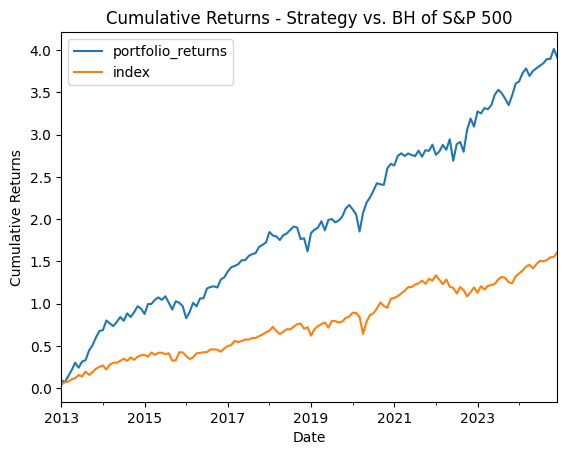

In [17]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 30, '2013-01-01', '2024-12-31', 'S&P 500')

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

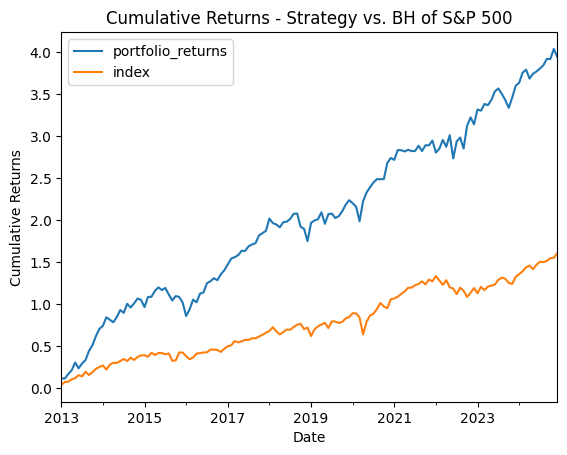

In [18]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 20, '2013-01-01', '2024-12-31', 'S&P 500')

### Apply strategy on S & P 500 ETFs 

In [22]:
overnight, intraday, total = monthly_data_sp500_etf()

[*********************100%***********************]  100 of 100 completed


In [23]:
macro_data = clean_format_data('sp500')

[*********************100%***********************]  2 of 2 completed


In [24]:
regimes = predict_next_regime(macro_data, 'sp500')

Model is not converging.  Current: 28.949506105131928 is not greater than 30.09908794049562. Delta is -1.1495818353636942
Model is not converging.  Current: 19.901320907132916 is not greater than 19.96538129513623. Delta is -0.0640603880033126
Model is not converging.  Current: 31.814229119534286 is not greater than 32.46747928192158. Delta is -0.6532501623872911
Model is not converging.  Current: 22.080265066702346 is not greater than 22.143053720630746. Delta is -0.0627886539284006
Model is not converging.  Current: 34.62426455863086 is not greater than 34.741397967920435. Delta is -0.11713340928957194
Model is not converging.  Current: 24.027005111529515 is not greater than 24.094341874480648. Delta is -0.06733676295113256
Model is not converging.  Current: 27.862689308215145 is not greater than 27.934597439260017. Delta is -0.07190813104487148
Model is not converging.  Current: 29.50475765114114 is not greater than 29.562031243068237. Delta is -0.057273591927096135
Model is not con

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

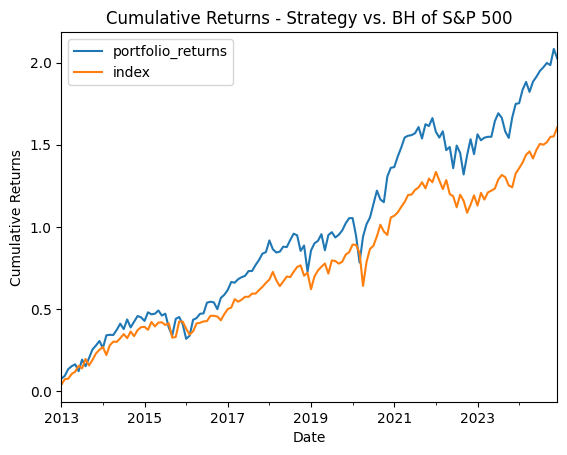

In [27]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 30, '2013-01-01', '2024-12-31', 'S&P 500') # Sharpe 0.812

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

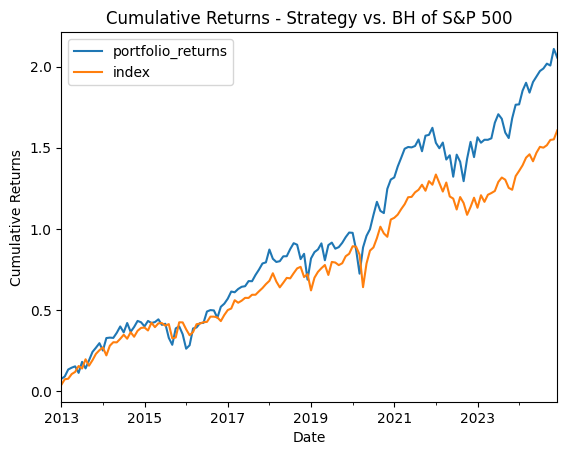

In [28]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 20, '2013-01-01', '2024-12-31', 'S&P 500') # Sharpe 0.822 

### Apply strategy on Nifty constituents 

In [32]:
overnight, intraday, total = monthly_data_nifty()

[*********************100%***********************]  50 of 50 completed

1 Failed download:
['ETERNAL.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 978287400, endDate = 1735583400")')


In [33]:
macro_data = clean_format_data('nifty')

[*********************100%***********************]  1 of 1 completed


In [34]:
regimes = predict_next_regime(macro_data, 'nifty')

Model is not converging.  Current: 15.663668480825933 is not greater than 15.67099620575151. Delta is -0.007327724925577428
Model is not converging.  Current: 17.15420215424335 is not greater than 17.16387021919416. Delta is -0.009668064950808741
Model is not converging.  Current: 19.682459808431847 is not greater than 19.69489327319517. Delta is -0.012433464763322633
Model is not converging.  Current: 21.11825264784049 is not greater than 21.132981909093917. Delta is -0.01472926125342866
Model is not converging.  Current: 22.41648124383327 is not greater than 22.42945357495786. Delta is -0.012972331124590397
Model is not converging.  Current: 25.379129913146336 is not greater than 25.383813193495453. Delta is -0.004683280349116359
Model is not converging.  Current: 26.89431704177698 is not greater than 26.898436100385947. Delta is -0.004119058608967663
Model is not converging.  Current: 28.334770277866014 is not greater than 28.336397374392845. Delta is -0.001627096526831906
Model is 

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

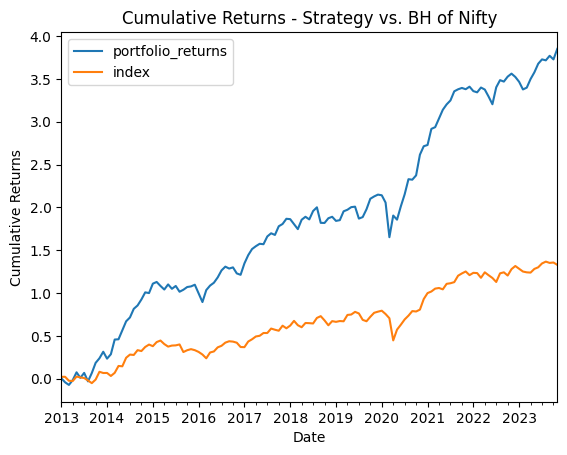

In [35]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 20, '2013-01-01', '2024-12-31', 'Nifty') # Sharpe: 1.22 

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

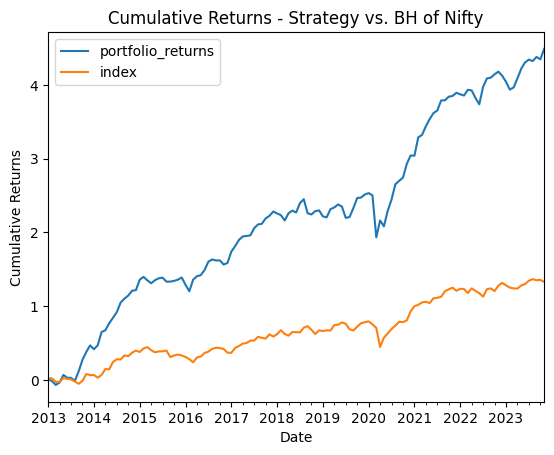

In [36]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 10, '2013-01-01', '2024-12-31', 'Nifty') # Sharpe: 1.25 

### Apply strategy on Nifty ETFs 

In [37]:
overnight, intraday, total = monthly_data_nifty_etf()

[*********************100%***********************]  200 of 200 completed

16 Failed downloads:
['EVIETF.NS', 'SILVERCASE.NS', 'AONELIQUID.NS', 'ECAPINSURE.NS', 'CASHIETF.NS', 'AONETOTAL.NS', 'MID150.NS', 'AONENIFTY.NS', 'GROWWMOM50.NS', 'CONSUMER.NS', 'MSCIINDIA.NS', 'MOCAPITAL.NS', 'GROWWN200.NS', 'GROWWRAIL.NS', 'GROWWSLVR.NS', 'SELECTIPO.NS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2001-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 978287400, endDate = 1735583400")')


In [38]:
macro_data = clean_format_data('nifty')

[*********************100%***********************]  1 of 1 completed


In [39]:
regimes = predict_next_regime(macro_data, 'nifty')

Model is not converging.  Current: 15.663668480825933 is not greater than 15.67099620575151. Delta is -0.007327724925577428
Model is not converging.  Current: 17.15420215424335 is not greater than 17.16387021919416. Delta is -0.009668064950808741
Model is not converging.  Current: 19.682459808431847 is not greater than 19.69489327319517. Delta is -0.012433464763322633
Model is not converging.  Current: 21.11825264784049 is not greater than 21.132981909093917. Delta is -0.01472926125342866
Model is not converging.  Current: 22.41648124383327 is not greater than 22.42945357495786. Delta is -0.012972331124590397
Model is not converging.  Current: 25.379129913146336 is not greater than 25.383813193495453. Delta is -0.004683280349116359
Model is not converging.  Current: 26.89431704177698 is not greater than 26.898436100385947. Delta is -0.004119058608967663
Model is not converging.  Current: 28.334770277866014 is not greater than 28.336397374392845. Delta is -0.001627096526831906
Model is 

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

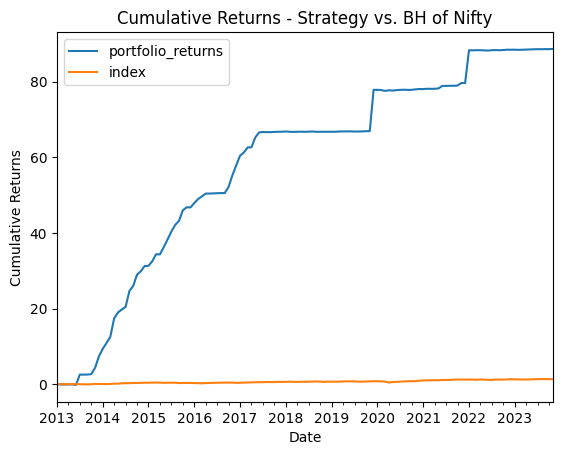

In [40]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 20, '2013-01-01', '2024-12-31', 'Nifty') # Sharpe : 1.57

Processing for 2013-01-01 00:00:00
Processing for 2013-02-01 00:00:00
Processing for 2013-03-01 00:00:00
Processing for 2013-04-01 00:00:00
Processing for 2013-05-01 00:00:00
Processing for 2013-06-01 00:00:00
Processing for 2013-07-01 00:00:00
Processing for 2013-08-01 00:00:00
Processing for 2013-09-01 00:00:00
Processing for 2013-10-01 00:00:00
Processing for 2013-11-01 00:00:00
Processing for 2013-12-01 00:00:00
Processing for 2014-01-01 00:00:00
Processing for 2014-02-01 00:00:00
Processing for 2014-03-01 00:00:00
Processing for 2014-04-01 00:00:00
Processing for 2014-05-01 00:00:00
Processing for 2014-06-01 00:00:00
Processing for 2014-07-01 00:00:00
Processing for 2014-08-01 00:00:00
Processing for 2014-09-01 00:00:00
Processing for 2014-10-01 00:00:00
Processing for 2014-11-01 00:00:00
Processing for 2014-12-01 00:00:00
Processing for 2015-01-01 00:00:00
Processing for 2015-02-01 00:00:00
Processing for 2015-03-01 00:00:00
Processing for 2015-04-01 00:00:00
Processing for 2015-

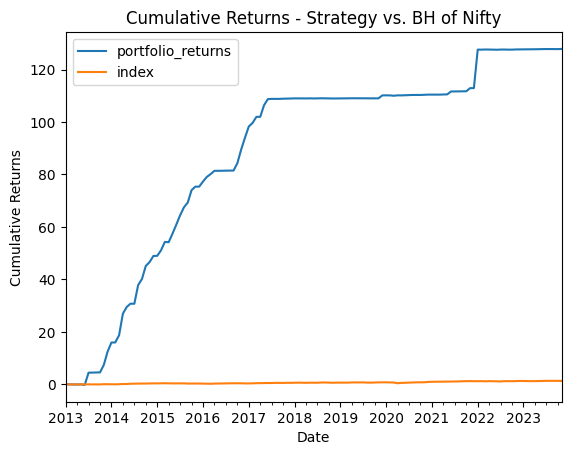

In [41]:
backtest_strategy(regimes, overnight, intraday, total, macro_data, 10, '2013-01-01', '2024-12-31', 'Nifty') # Sharpe : 1.49 